This notebook examines the abrupt experiments which follow a 500 year spinup.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client()
display(client)

Client Scheduler: tcp://127.0.0.1:46797 Dashboard: /proxy/46239/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,150429
1,output111,2096
2,output112,2096
3,output113,2096
4,output114,2096
5,output115,2096
6,output116,2096
7,output117,2096
8,output118,2096
9,output119,2096


## Analysis

In what follows, only the period 2400-2500 will be analysed, since this is the period over which the perturbations experiments have been run.

In [5]:
### Control

expt = '1deg_jra55_ryf_cont'
control = cc.querying.get_variables(session, experiment = expt)
yr_beg = '2399-01-16'
yr_end = '2499-12-16'

# 3D temperature array
temp_control = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').sel(time = slice(yr_beg, None)).chunk(chunks='auto')
for i in range(1,10):
    da = cc.querying.getvar('output11{}'.format(i), 'temp', session, frequency = '1 monthly')
    temp_control = xr.concat([temp_control, da],dim='time')

# Global average temp    
GAT_control = cc.querying.getvar(expt, 'temp_global_ave', session).sel(time = slice(yr_beg, None)).groupby('time.year').mean('time')[:-1].chunk(chunks='auto') # Cuts off year 2455, included in next array
for i in range(1,10):
    da = cc.querying.getvar('output11{}'.format(i), 'temp_global_ave', session)[:-1].groupby('time.year').mean('time')
    GAT_control = xr.concat([GAT_control, da], dim='year')
    
# SST
SST_control = cc.querying.getvar(expt, 'temp_surface_ave', session).sel(time = slice(yr_beg, None)).groupby('time.year').mean('time')[:-1]
for i in range(1,10):
    da = cc.querying.getvar('output11{}'.format(i), 'temp_surface_ave', session)[:-1].groupby('time.year').mean('time')
    SST_control = xr.concat([SST_control, da], dim='year')

In [6]:
### Cool

expt = '1deg_jra55_ryf_rcp45cool_spinup500'
cool = cc.querying.get_variables(session, experiment = expt)

temp_cool = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto') 
GAT_cool = cc.querying.getvar(expt, 'temp_global_ave', session).groupby('time.year').mean('time')[:-1].chunk(chunks='auto') # Cuts off 2500, only one entry
SST_cool = cc.querying.getvar(expt, 'temp_surface_ave', session).groupby('time.year').mean('time')[:-1].chunk(chunks='auto') # Cuts off 2500, only one entry

In [7]:
### Warm

expt = '1deg_jra55_ryf_rcp45warm_spinup500'
cool = cc.querying.get_variables(session, experiment = expt)

temp_warm = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly').chunk(chunks='auto')   
GAT_warm = cc.querying.getvar(expt, 'temp_global_ave', session).groupby('time.year').mean('time')[:-1].chunk(chunks='auto')
SST_warm = cc.querying.getvar(expt, 'temp_surface_ave', session).groupby('time.year').mean('time')[:-1]

In [8]:
# Load into memory

GAT_control = GAT_control.load()
SST_control = SST_control.load()

In [9]:
GAT_cool = GAT_cool.load()
SST_cool = SST_cool.load()

In [10]:
GAT_warm = GAT_warm.load()
SST_warm = SST_warm.load()

In [11]:
### Dedrift using a cubic

def cubic(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

t = GAT_control['year'].values
popt, pcov = curve_fit(cubic, t, GAT_control[:,0])
GAT_trend = cubic(t, *popt)

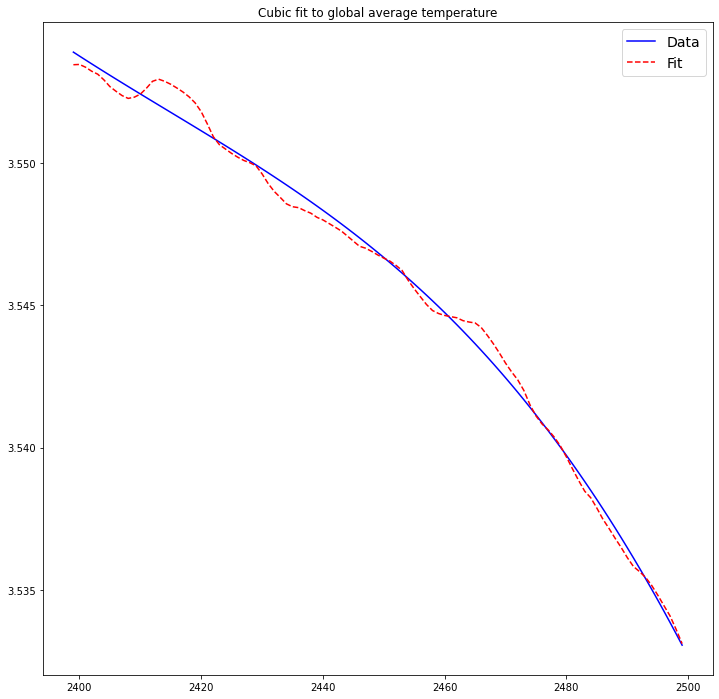

In [85]:
plt.figure(figsize=(12,12))
plt.plot(t, GAT_trend, label='Data', color = 'b')
plt.plot(t, GAT_control[:,0], label='Fit', color = 'r', linestyle = '--')
plt.title('Cubic fit to global average temperature')
plt.legend(fontsize=14)

Text(0.5, 1.0, 'SST')

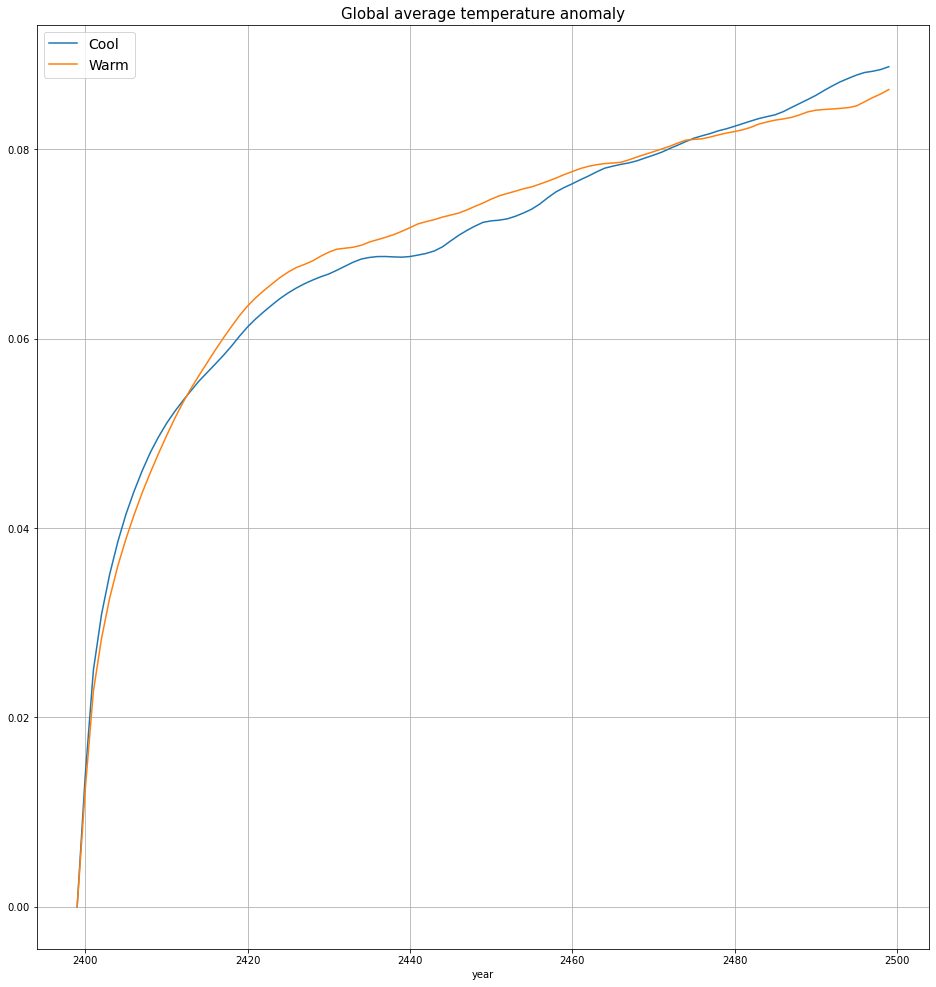

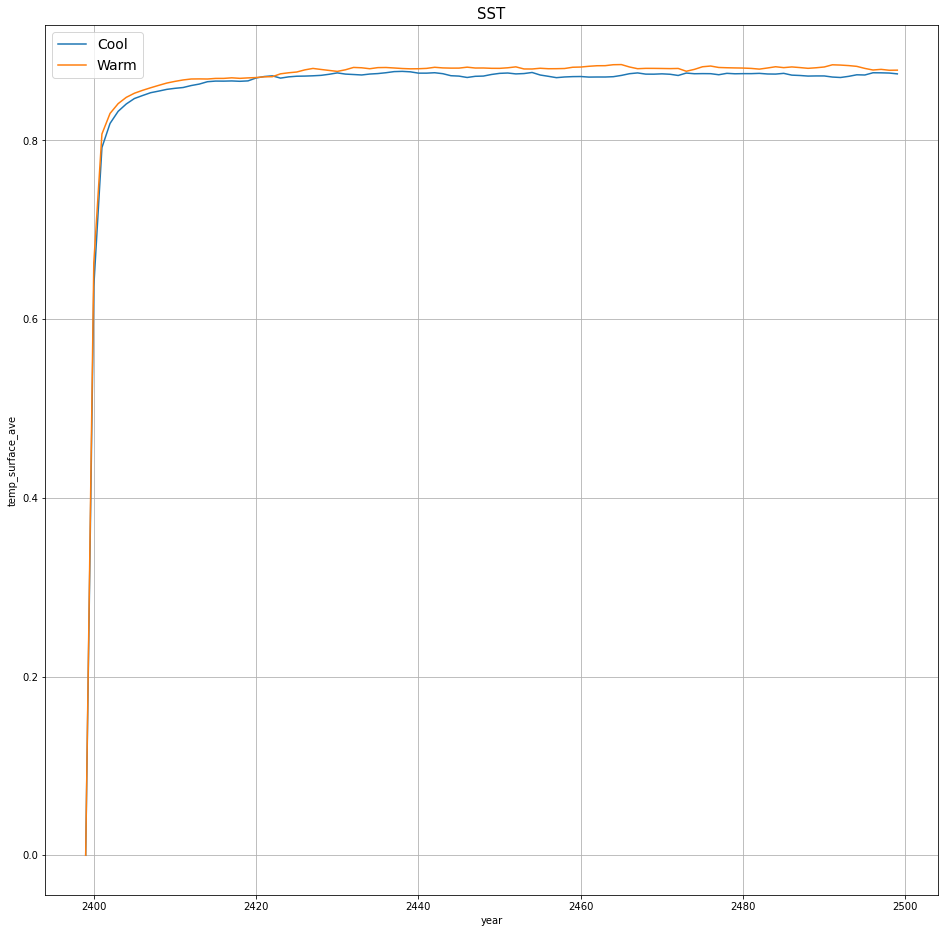

In [87]:
# GAT
plt.figure(figsize = (16,17))
GAT_trend_2399 = xr.DataArray(data=[GAT_trend[0]],dims='year', coords={"year": [2399]})
GAT_cool_plotting = xr.concat([GAT_trend_2399, GAT_cool], dim='year')[:,0]
GAT_warm_plotting = xr.concat([GAT_trend_2399, GAT_warm], dim='year')[:,0]
(GAT_trend - GAT_cool_plotting).plot(label='Cool')
(GAT_warm_plotting - GAT_trend).plot(label='Warm')

plt.grid()
plt.legend(fontsize=14)
plt.title('Global average temperature anomaly', fontsize=15)

# SST
plt.figure(figsize = (16,16))
SST_cool_plotting = xr.concat([SST_control[0,:], SST_cool], dim='year')
SST_warm_plotting = xr.concat([SST_control[0,:], SST_warm], dim='year')
(SST_control - SST_cool_plotting).plot(label='Cool')
(SST_warm_plotting - SST_control).plot(label='Warm')

plt.grid()
plt.legend(fontsize=14)
plt.title('SST', fontsize=15)
#plt.savefig('SST spin-up')

In [100]:
# Analysing global average temperature over time

np.cumsum(GAT_trend[1:]) - np.cumsum(GAT_cool)[:,0], np.cumsum(GAT_warm)[:,0] - np.cumsum(GAT_trend[1:])

(<xarray.DataArray 'temp_global_ave' (year: 100)>
 array([0.01389488, 0.03888802, 0.06976002, 0.10485541, 0.14338433,
        0.18481335, 0.22867518, 0.27470827, 0.32266723, 0.37226506,
        0.42330594, 0.47560034, 0.52902709, 0.5835158 , 0.63903577,
        0.69545281, 0.75276571, 0.81099224, 0.8701959 , 0.93046811,
        0.9917186 , 1.05381964, 1.11667379, 1.18024034, 1.24449166,
        1.30933286, 1.37468891, 1.44049304, 1.50668641, 1.5732264 ,
        1.640064  , 1.70730155, 1.77496202, 1.84304543, 1.91146313,
        1.98005017, 2.04873058, 2.11741663, 2.18605906, 2.25467652,
        2.32335842, 2.39219817, 2.46120841, 2.53047998, 2.60018258,
        2.6705046 , 2.74142572, 2.81285837, 2.88475197, 2.95704373,
        3.02949375, 3.10202019, 3.17468685, 3.24762436, 3.3209098 ,
        3.39459625, 3.46882764, 3.54373257, 3.61924714, 3.69521906,
        3.77158648, 3.84837944, 3.92557106, 4.00319524, 4.08121222,
        4.15944332, 4.23786408, 4.31644224, 4.39524324, 4.47434642